# Propagación de ondas en pilotes

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
warnings.filterwarnings('ignore')

## Datos del pilote

In [6]:
lpilote = 10      # Longitud pilote
k = 0             # Rigidez friccional
c = 0             # Amortiguamiento lateral
K = 1000          # Rigidez de punta
C = 0             # Amortiguamiento en punta
E = 30e9          # Módulo de elasticidad
gamma = 24e3      # Peso específico
ro = gamma/9.81   # Densidad
A = 1             # Área transversal del elemento
S = 1             # Perímetro del elemento      

## Definición de elementos de análisis

In [7]:
nelem=100              # Número de elementos finitos
li=lpilote/nelem       # Longitud de los elementos individuales
nnodelem=2             # Número de nodos por elementos
nnod=nelem+1           # Número de nodos globales
npg=2                  # Número de puntos de Gauss

pg   = np.array([-0.5774,0.5774]) # puntos de Gauss
ppg  = np.array([1,1])            # peso de los puntos de Gauss
Jac  = li/2                       # Jacobiano del cambio de variable = dx/dr
invJ = 1/Jac                      # Inversa del jacobiano = dr/dx
DH   = np.array([-1/2,1/2])[np.newaxis]       # Jacobiano de la matriz de funciones de forma

# Integración numérica
gamma=0.56;              # Constantes de integración del método
beta=0.25*(0.5+gamma)**2

Vp=math.sqrt(E/ro)     # Velocidad de propagación longitudinal
dt=li/(Vp)/2           # Paso temporal
nt=8*nelem             # Número de pasos para la integración temporal
T=nt*dt                # Duracion total en segundos

## Definición de la excitación


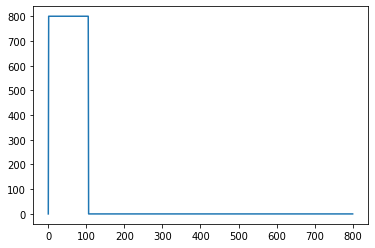

In [8]:
Tex  = 0.0015              # Duración de la excitación
npex = int(round(Tex/dt))  # Número de pasos de la excitación
Q    = 800                 # Amplitud
P    = np.zeros(nt+1)
P[1:int(npex+1)] = Q*np.ones(int(npex))
plt.plot(P)

## Definición de matrices elementales

In [9]:
# Integración con Gauss
eIG=np.zeros((nnodelem,nnodelem))    # Matrices bases para la integración
iIG=np.zeros_like(eIG)
for i in range(pg.size):
    r=pg[i]            # Punto de Gauss
    # Evaluación de las funciones de forma respecto de la coordenada natural
    Hpg = np.array([(1/2)*(1-r),(1/2)*(1+r)])[np.newaxis]
    # Matrices elementales para H y DH
    eIG=eIG+(Hpg.T)*(Hpg)*ppg[i]*Jac
    iIG=iIG+(invJ*DH.T)*(invJ*DH)*ppg[i]*Jac

## Ensamble de matrices

In [10]:
# Ensamble de matrices
eE=np.zeros((nnod,nnod)) # Matrices bases para el ensamble
iE=np.zeros((nnod,nnod)) 
for i in range(int(nnod-1)):
    eE[i:i+2,i:i+2]=eE[i:i+2,i:i+2]+eIG
    iE[i:i+2,i:i+2]=iE[i:i+2,i:i+2]+iIG

### Corrección de matrices según parámetros del problema

In [11]:
# Matrices elementales
MM=eE/Vp**2         # Matriz de masa elemental              
MC=eE*c*S/(E*A)     # Matriz de amortiguamiento elemental
MK=eE*k*S/(E*A)     # Matriz de rigidez elemental
MI=iE              # Matriz de inercia elemental

## Resolución del sistema

In [12]:
#Condiciones iniciales
u      = np.zeros((nnod,nt+1))
du     = np.zeros((nnod,nt+1))
ddu    = np.zeros((nnod,nt+1))
sigmax = np.zeros((nnod-1,nt+1))

for i in range(int(nt)):
    Aaux=MM/(dt**2*beta)+MI+MK+MC*gamma/(dt*beta)
    Aaux[-1,-1]=Aaux[-1,-1]+K/(A*E)+C*gamma/(A*E*dt*beta)
    
    Baux=np.dot(MM,(u[:,i]/(dt**2*beta)+du[:,i]/(dt*beta)+(1/(2*beta)-1)*ddu[:,i]))-np.dot(MC,(du[:,i]+dt*(1-gamma)*ddu[:,i]-gamma*(u[:,i]/(dt*beta)+du[:,i]/beta+dt*(1/(2*beta)-1)*ddu[:,i])))
    Baux[-1]=Baux[-1]-C/(A*E)*(du[-1,i]+dt*(1-gamma)*ddu[-1,i]-gamma*(u[-1,i]/(dt*beta)+du[-1,i]/beta+dt*(1/(2*beta)-1)*ddu[-1,i]))
    Baux[0]=Baux[0]+P[i+1]/(E*A)    
    
    u[:,i+1]=np.linalg.solve(Aaux,Baux)
    ddu[:,i+1]=(u[:,i+1]-u[:,i])/(dt**2*beta)-du[:,i]/(dt*beta)-(1/(2*beta)-1)*ddu[:,i]
    du[:,i+1]=du[:,i]+dt*((1-gamma)*ddu[:,i]+gamma*ddu[:,i+1])
    
    for j in range(nelem):
        sigmax [j,i+1] = E*invJ*np.dot(DH,u[j:j+2,i+1])

## Propagación de velocidades y tensiones

In [13]:
x  = np.linspace(0.0,lpilote,num=int(nnod))
xs = np.linspace(li/2,lpilote-li/2,num=int(nnod-1))

def vel(t):
  plt.plot(x,du[:,t]*1000)
  plt.xlabel('x [m]')
  plt.ylabel('du [mm/s]')
  plt.grid()
  plt.ylim([-np.max(abs(du*1000))*1.2,np.max(abs(du*1000))*1.2])
  txt='t=',t*dt,'s'
  plt.title(txt)

interact(vel, t=widgets.IntSlider(min=0,max=nt,step=1,value=0))

def sigma(t):
  plt.plot(xs,sigmax[:,t]*1000)
  plt.xlabel('x [m]')
  plt.ylabel('$\sigma$ [kPa]')
  plt.grid()
  plt.ylim([-np.max(abs(sigmax*1000))*1.2,np.max(abs(sigmax*1000))*1.2])
  txt='t=',t*dt,'s'
  plt.title(txt)

interact(sigma, t=widgets.IntSlider(min=0,max=nt,step=1,value=0))


interactive(children=(IntSlider(value=0, description='t', max=800), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=0, description='t', max=800), Output()), _dom_classes=('widget-interact'…

<function __main__.sigma>